# Practico 2 - Redes Bayesianas y Estimación de distribuciones continuas.

El objetivo de esta notebook es implementar las redes bayesianas sobre el dataset de Tennis y continuar explorando formas de estimar distribuciones pero esta vez sobre datos continuos. 

## Parte 1: Redes Bayesianas

## Imports

In [589]:
#!pip install pgmpy

In [590]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

### Paso 1: Cargar los Datos y Construir el Modelo

In [591]:
# Cargar los datos
data = pd.read_csv('./tennis.csv')
data.head()

,Day,Outlook,Temp,Humidity,Wind,Tennis
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


Definimos variables aleatorias que vamos a usar. Por simplicidad en la visualización solo usaremos 3, pero puede usar todas las que quiera.

In [592]:
outlook = 'Outlook'
temp = 'Temp'
wind = 'Wind'
humidity = 'Humidity'
tennis = 'Tennis'

data_1 = data[[outlook, temp, tennis]]

Tenemos que definir las relaciones condicionales que hay entre estas variables, para eso vamos a definir las siguientes relaciones: 

- Tennis depende de Outlook
- Tennis depende de Temp

In [593]:
relations = [(outlook, tennis), (temp, tennis)]

Teniendo las relaciones vamos a crear nuestro modelo!

In [594]:
model = DiscreteBayesianNetwork(relations)

Ahora que tenemos el modelo vamos a ajustarlo para que capture las probabilidades condicionales en las observaciones.

In [595]:
# Aprender los CPDs desde los datos
model.fit(data_1, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Outlook': 'C', 'Temp': 'C', 'Tennis': 'C'}


Verificamos si el modelo es valido.

In [596]:
model.check_model()

True

### Paso 2: Visualización del Grafo y CPDs

In [597]:
def visualize_graph(model):
    G = nx.DiGraph()
    G.add_edges_from(model.edges())
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=10000, node_color="skyblue", font_size=14, font_weight="bold", arrowsize=30)
    plt.title("Red Bayesiana del Dataset de Tenis")
    plt.show()

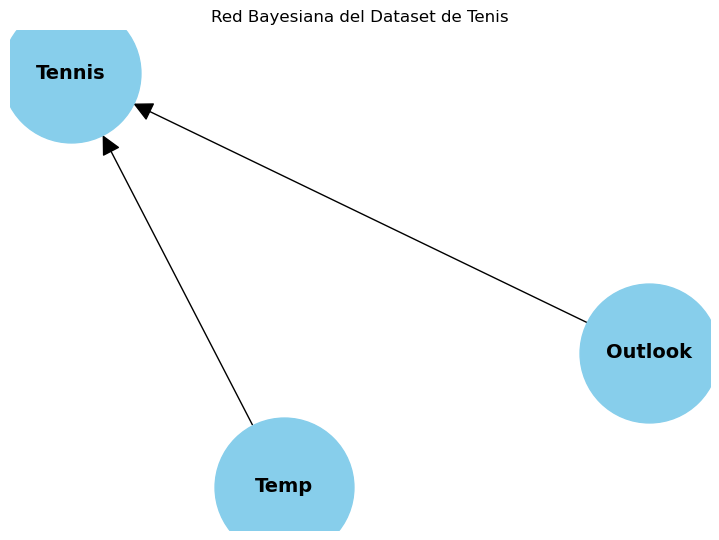

In [598]:
visualize_graph(model)

In [599]:
for cpd in model.get_cpds():
    print(f"CPD de {cpd.variable}:")
    print(cpd)

CPD de Outlook:
+-------------------+----------+
| Outlook(Overcast) | 0.285714 |
+-------------------+----------+
| Outlook(Rain)     | 0.357143 |
+-------------------+----------+
| Outlook(Sunny)    | 0.357143 |
+-------------------+----------+
CPD de Tennis:
+-------------+-------------------+-----+----------------+----------------+
| Outlook     | Outlook(Overcast) | ... | Outlook(Sunny) | Outlook(Sunny) |
+-------------+-------------------+-----+----------------+----------------+
| Temp        | Temp(Cool)        | ... | Temp(Hot)      | Temp(Mild)     |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(No)  | 0.0               | ... | 1.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
| Tennis(Yes) | 1.0               | ... | 0.0            | 0.5            |
+-------------+-------------------+-----+----------------+----------------+
CPD de Temp:
+------------+----------+
| Temp(Cool) | 

### Explicación:
- **Estructura de la Red:** Los arcos en la red representan la relación de causa y efecto entre las variables. Aquí, las condiciones del clima influyen en la decisión de jugar tenis.
- **CPDs:** Cada nodo tiene un CPD que describe la distribución de probabilidad condicional de la variable dada sus padres.

¿Por qué la tabla de Outlook y Temp solamente una columna mientras que la de Tennis tiene varias?

¿Cuántas columnas tiene la de Tennis? ¿Por qué?

### *Respuestas*

##### **Respuesta A:** Outlook y Temp tiene solo una columna porque no tienen padres. Es decir, que su distribucion no depende de otras variables de la tabla de datos.

##### **Respuesta B:** Tiene 9 columnas, son tres categorias de Outlook y tres cateogorias de Temp. En total hay 9 posibles pares de combinaciones entre las dos variables.

In [600]:
for cpd in model.get_cpds():
    print(f"Variable: {cpd.variable}")
    print("  Estados:")
    for state in cpd.state_names[cpd.variable]:
        print(f"    - {state}")
    print(f"  Cardinalidad: {cpd.variable_card}\n")

Variable: Outlook
  Estados:
    - Overcast
    - Rain
    - Sunny
  Cardinalidad: 3

Variable: Tennis
  Estados:
    - No
    - Yes
  Cardinalidad: 2

Variable: Temp
  Estados:
    - Cool
    - Hot
    - Mild
  Cardinalidad: 3



- **Cardinalidad:** Indica cuántos estados puede tener una variable.

### Paso 3: Inferencia en la Red

**Inferencia:** Dado un conjunto de evidencias (ej. Outlook y Temp), la red calcula la probabilidad de que Tennis sea 'Yes' o 'No'.

In [601]:
# Inferencia en la red bayesiana
inferencia = VariableElimination(model)
resultado = inferencia.query(variables=[tennis], evidence={outlook: 'Sunny', temp: 'Mild'})
print("\nResultado de la inferencia:")
print(resultado)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


### Ejercicios:
1. Realice inferencias usando diferentes combinaciones de evidencias para observar cómo cambian las probabilidades.
2. Cree otro modelo con diferentes relaciones y realice inferencias sobre este.
 Recuerde que puede agregar más variables (como por ej. Humudity o Wind).

##### 1. Diferentes inferencias en base a combinaciones de evidencias.

In [602]:
prueba_1 = inferencia.query(variables=[tennis], evidence={outlook: 'Overcast', temp: 'Hot'})
print("\nResultado de la inferencia:")
print(prueba_1)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.0000 |
+-------------+---------------+
| Tennis(Yes) |        1.0000 |
+-------------+---------------+


In [603]:
prueba_2 = inferencia.query(variables=[tennis], evidence={outlook: 'Rain', temp: 'Hot'})
print("\nResultado de la inferencia:")
print(prueba_2)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.5000 |
+-------------+---------------+
| Tennis(Yes) |        0.5000 |
+-------------+---------------+


##### 2. Modelo con distintas relaciones

In [604]:
relations = [(outlook, tennis), (temp, tennis), (humidity, tennis), (wind, tennis)]
data_2 = data[[outlook, temp, humidity, wind, tennis]]

In [605]:
model = DiscreteBayesianNetwork(relations)

In [606]:
# Aprender los CPDs desde los datos
model.fit(data_2, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Outlook': 'C', 'Temp': 'C', 'Humidity': 'C', 'Wind': 'C', 'Tennis': 'C'}


In [607]:
model.check_model()

True

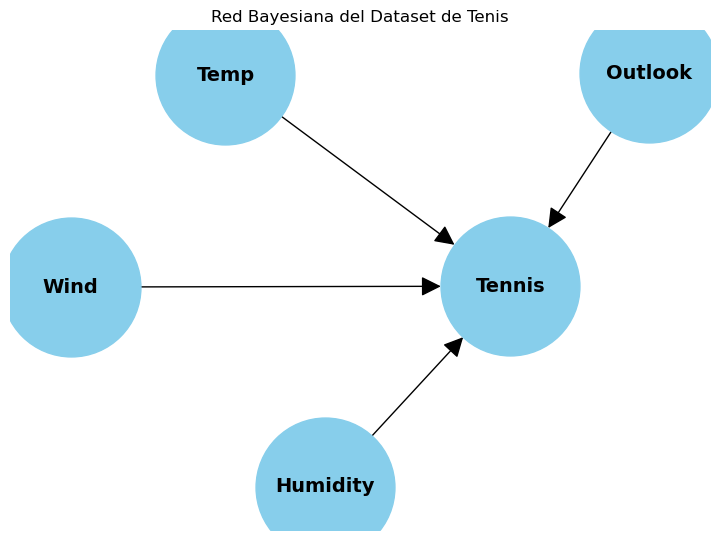

In [608]:
visualize_graph(model)

In [609]:
inferencia = VariableElimination(model)
prueba_3 = inferencia.query(variables=[tennis], evidence={outlook: 'Overcast', temp: 'Hot', humidity: 'High'})
print("\nResultado de la inferencia:")
print(prueba_3)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        0.2143 |
+-------------+---------------+
| Tennis(Yes) |        0.7857 |
+-------------+---------------+


In [610]:
prueba_4 = inferencia.query(variables=[tennis], evidence={outlook: 'Sunny', temp: 'Mild', humidity: 'High', wind: 'Weak'})
print("\nResultado de la inferencia:")
print(prueba_4)


Resultado de la inferencia:
+-------------+---------------+
| Tennis      |   phi(Tennis) |
+=============+===============+
| Tennis(No)  |        1.0000 |
+-------------+---------------+
| Tennis(Yes) |        0.0000 |
+-------------+---------------+


## Parte 2: Estimando distribuciones continuas.

El objetivo de esta notebook es explorar una primera manera de aproximar $p(x|y)$ y $p(y|x)$ en un dataset tabular donde $x\in\mathbb{R}^k$ y el objetivo $y$ es una variable discreta y finita $y\in\{0,\ldots,d\}⊆\mathbb{N}, d\geq 1$.

### Imports

In [611]:
import numpy as np
import seaborn as sns

from sklearn import datasets
from matplotlib import pyplot as plt

### Cargamos el dataset

In [612]:
iris = datasets.load_iris()

In [613]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [614]:
X = iris.data
y = iris.target

In [615]:
iris_df = pd.DataFrame(data=X,
             columns=iris.feature_names,
             )

iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Para simplificar el problema solo trabajaremos con una variable aleatoria.

Filtramos el dataset por feature.

feature_number puede ser 0, 1, 2, 3
- 0 - sepal length (cm)
- 1 - sepal width (cm)
- 2 - petal length (cm)
- 3 - petal width (cm)

In [616]:
feature_number = 0
feature_name = iris.feature_names[feature_number]
xfeature_original = X[:,feature_number]
xfeature_original

array([5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
       4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
       5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
       5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
       6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
       6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
       6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
       6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
       6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
       7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
       7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
       6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9])

Como estamos trabajando con valores continuos, vamos a discretizarlos.

Para ello, vamos a utilizar la funcion linspace de numpy, que nos permite dividir un rango en n partes iguales. https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

Hacemos el siguiente calculo para tener la cantidad de bins que deseamos ya que la librería siempre nos crea uno más.

In [617]:
NBINS = 10
bin_size = (np.max(xfeature_original) - np.min(xfeature_original)) / NBINS
end = np.max(xfeature_original) - bin_size
bins = np.linspace(start=np.min(xfeature_original), stop=end, num=NBINS)

bins

array([4.3 , 4.66, 5.02, 5.38, 5.74, 6.1 , 6.46, 6.82, 7.18, 7.54])

In [618]:
xfeature_digitized = np.digitize(x=xfeature_original, bins=bins)
xfeature_digitized

array([ 3,  2,  2,  1,  2,  4,  1,  2,  1,  2,  4,  2,  2,  1,  5,  4,  4,
        3,  4,  3,  4,  3,  1,  3,  2,  2,  2,  3,  3,  2,  2,  4,  3,  4,
        2,  2,  4,  2,  1,  3,  2,  1,  1,  2,  3,  2,  3,  1,  3,  2,  8,
        6,  8,  4,  7,  4,  6,  2,  7,  3,  2,  5,  5,  6,  4,  7,  4,  5,
        6,  4,  5,  6,  6,  6,  6,  7,  7,  7,  5,  4,  4,  4,  5,  5,  4,
        5,  7,  6,  4,  4,  4,  6,  5,  2,  4,  4,  4,  6,  3,  4,  6,  5,
        8,  6,  7, 10,  2,  9,  7,  9,  7,  6,  7,  4,  5,  6,  7, 10, 10,
        5,  8,  4, 10,  6,  7,  9,  6,  6,  6,  9,  9, 10,  6,  6,  6, 10,
        6,  6,  5,  8,  7,  8,  5,  7,  7,  7,  6,  7,  6,  5])

### Aproximamos $p(x|y)$

Para calcular la distribución $p (x | y)$ usamos *distplot kde* (Kernel Density Estimation) para cada clase con los datos originales (datos continuos y no los discretizados).

Para este paso aprovechamos que el dataset esta ordenado por clase.

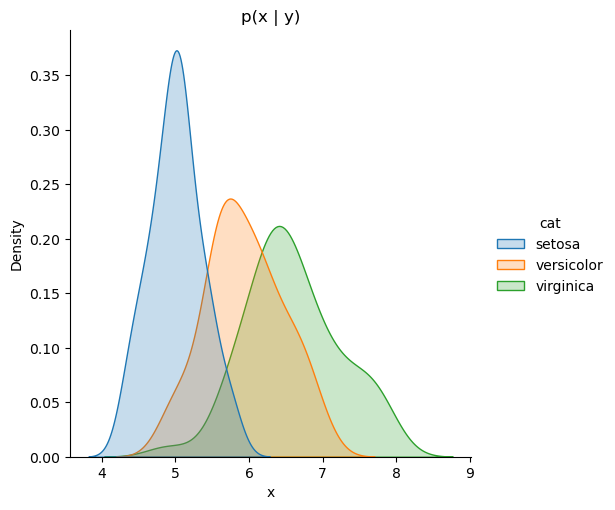

In [619]:
pd_cats = pd.DataFrame(xfeature_original.flatten(), columns=['x'])
pd_cats['cat'] = np.concatenate((np.full(50, 'setosa'),
                                np.full(50, 'versicolor'),
                                np.full(50, 'virginica')))
sns.displot(
    data=pd_cats, x='x', kind='kde',
    hue='cat', fill=True
)

plt.title('p(x | y)')
plt.show()

¿Qué nos muestra esta gráfica?

¿Qué conclusiones puede sacar?

### *Respuestas*

##### **Respuesta A**: Nos muestra la distribución por clase de la flor, en base a la característica elegida "X" (largo del sepalo).

##### **Respuesta B**: Como conclusión, parecería existir cierta correlación entre el largo del sepalo y la clase de la flor. Por ejemplo, a partir de los 8 centímetros de largo del sepalo todas las flores son de clase virginica. Otra observación: la clase setosa se encuentra toda distribuida entre los 4 y 5 cms.

Ejercicio: Grafique un histograma para cada clase que nos muestre $p (bin| y = clase)$ utilizando los datos discretizados. Puede utilizar la función *np.histogram*. https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

Luego compare los histogramas con la gráfica de arriba sobre $p (x | y)$.

### *Solucion*

Text(0.5, 0, 'sepal length (cm)')

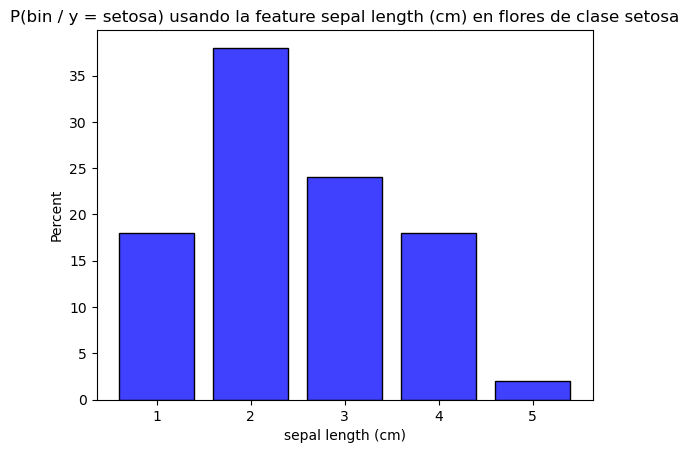

In [620]:
pd_disc_feature = pd.DataFrame(xfeature_digitized[:50], columns=[feature_name])
sns.histplot(data=pd_disc_feature, x=feature_name, discrete=True, stat='percent', color='blue', shrink=0.8)
plt.title('P(bin / y = setosa) usando la feature ' + feature_name + ' en flores de clase setosa')
plt.xlabel(feature_name)

Text(0.5, 0, 'sepal length (cm)')

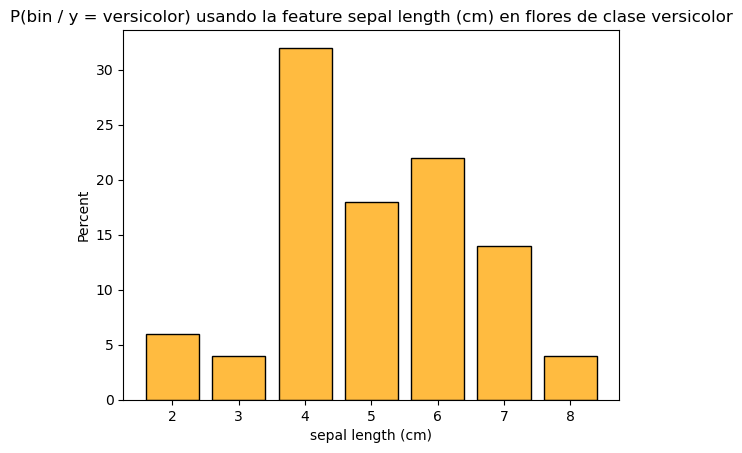

In [621]:
pd_disc_feature = pd.DataFrame(xfeature_digitized[50:100], columns=[feature_name])
sns.histplot(data=pd_disc_feature, x=feature_name, discrete=True, stat='percent', color='orange', shrink=0.8)
plt.title('P(bin / y = versicolor) usando la feature ' + feature_name + ' en flores de clase versicolor')
plt.xlabel(feature_name)

Text(0.5, 0, 'sepal length (cm)')

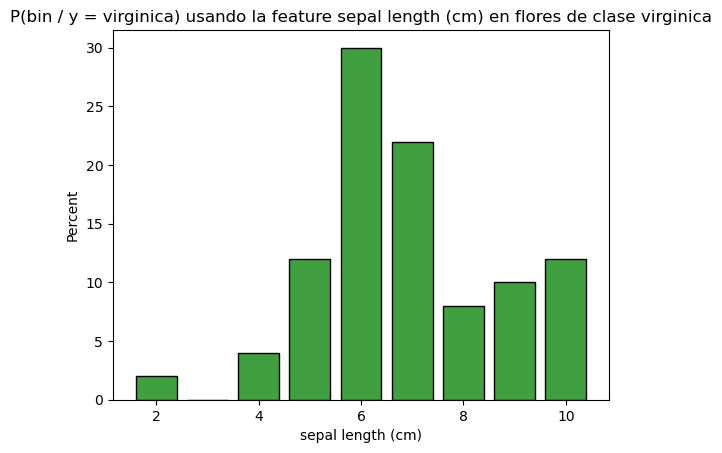

In [622]:
pd_disc_feature = pd.DataFrame(xfeature_digitized[100:150], columns=[feature_name])
sns.histplot(data=pd_disc_feature, x=feature_name, discrete=True, stat='percent', color='green', shrink=0.8)
plt.title('P(bin / y = virginica) usando la feature ' + feature_name + ' en flores de clase virginica')
plt.xlabel(feature_name)

### *Respuesta*

##### Los histogramas son coherentes. Por ejemplo, para la clase setosa, mayormente concentrada en sepalos de largo entre 4 y 6 centímetros. La p(x/y=setosa) esta concentrada en los primeros bins. Ya que sus sepalos son cortos, en comparación a las otras dos clases. Los bins con mayor probabilidad condicional son el bin 2 y 3 que es donde quedaron discretizados los sepalos de 5cm, característica que comparten varias de las flores de clase setosa. Siguiendo ese ejemplo basta con comparar el orden de los bins de los histogramas de probabilidad condicionada por clase de flor. Para ver como son coherentes con la primera gráfica de distribución.

### Aproximamos $p(y|x)$

Estime la probabilidad condicional de *y* dado *x* y luego muestree 10 valores de y dado que $x = 4.75$

In [623]:
pd_disc_with_y = pd.DataFrame(xfeature_digitized.flatten(), columns=['bin'])
pd_disc_with_y['y'] = np.concatenate((np.full(50, 'setosa'),
                                np.full(50, 'versicolor'),
                                np.full(50, 'virginica')))

In [624]:
# Feature discretizada
p_y_x = pd.crosstab(index=pd_disc_with_y['y'], columns=pd_disc_with_y['bin'], normalize='columns')

p_y_x = p_y_x.fillna(0)

p_y_x

bin,1,2,3,4,5,6,7,8,9,10
y,,,,,,,,,,
setosa,1.0,0.826087,0.857143,0.333333,0.0625,0.000000,0.000000,0.000000,0.0,0.0
versicolor,0.0,0.130435,0.142857,0.592593,0.5625,0.423077,0.388889,0.333333,0.0,0.0
virginica,0.0,0.043478,0.000000,0.074074,0.3750,0.576923,0.611111,0.666667,1.0,1.0


In [625]:
# Feature original continua
p_y_x_cont = pd.crosstab(index=pd_cats['cat'], columns=pd_cats['x'], normalize='columns')

p_y_x_cont

x,4.3,4.4,4.5,4.6,4.7,4.8,4.9,5.0,5.1,5.2,...,6.8,6.9,7.0,7.1,7.2,7.3,7.4,7.6,7.7,7.9
cat,,,,,,,,,,,,,,,,,,,,,
setosa,1.0,1.0,1.0,1.0,1.0,1.0,0.666667,0.8,0.888889,0.75,...,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
versicolor,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.2,0.111111,0.25,...,0.333333,0.25,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
virginica,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,0.00,...,0.666667,0.75,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [626]:
x = 4.75
x_disc = np.digitize(x=x, bins=bins)

x_disc

np.int64(2)

In [627]:
bin_dist = p_y_x[x_disc]

y_sample = []
for _ in range(10):
    y_sample.append(np.random.choice(a=p_y_x.index, p=bin_dist))

y_sample


['setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'setosa',
 'versicolor',
 'setosa']

### Sampleamos sobre *p(x|y)*

Realice una muestra de 50 valores de $x$ para cada valor de $y$. Recomendamos utilizar la función *gaussian_kde* de *scipy.stats*.

In [628]:
pd_cats.head()

,x,cat
0,5.1,setosa
1,4.9,setosa
2,4.7,setosa
3,4.6,setosa
4,5.0,setosa


In [629]:
data_filter_a = pd_cats[pd_cats['cat'] == 'setosa']

data_filter_a.head()

,x,cat
0,5.1,setosa
1,4.9,setosa
2,4.7,setosa
3,4.6,setosa
4,5.0,setosa


In [ ]:
from scipy.stats import gaussian_kde
from collections import defaultdict

samples_by_cat = defaultdict(list)

for category in pd_cats['cat'].unique():
    data_filtered = pd_cats[pd_cats['cat'] == category]

    kde_data = gaussian_kde(data_filtered['x'])

    samples_by_cat[category] = kde_data.resample(50).ravel() # kde_date es de (1x50), ravel lo pasa a (50,)

samples_by_cat


defaultdict(list,
            {'setosa': array([4.61499969, 5.57892453, 4.88221978, 4.7968972 , 4.38762874,
                    5.37089921, 5.53031231, 5.11729283, 4.64173043, 4.81067619,
                    4.39717221, 5.39634578, 4.98357869, 5.07319427, 5.27568132,
                    5.46327048, 5.50358739, 5.00404189, 5.15480605, 5.32543834,
                    5.28400644, 4.69556452, 4.78545586, 5.18725475, 4.30532032,
                    4.85532983, 4.60415473, 4.6845501 , 4.5312238 , 5.07554013,
                    4.74963738, 5.76412811, 5.27058685, 4.63557439, 5.05066676,
                    5.17211937, 5.79647262, 4.51350885, 5.01563052, 5.48761655,
                    5.00390772, 5.42718772, 4.90287732, 5.29483974, 5.13299279,
                    4.42444584, 4.94610163, 4.91664981, 4.252962  , 5.21442132]),
             'versicolor': array([6.51154051, 6.87726167, 5.834068  , 5.34845728, 5.62776155,
                    6.84787817, 5.09989017, 6.19543832, 5.67861676, 4.935786

Grafique $p(x|y)$ utilizando los datos sampleados y compare con la gráfica de $p(x|y)$ creada con los datos originales.

In [ ]:
#### Flatear y usar displot de seaborn y deberia de quedar similar.

### Aproximamos la distribución normal de $p(x|y)$

In [216]:
'''
Separamos los datos de cada clase

setosa_feature = xfeature_original[:50]
versicolor_feature = xfeature_original[51:100]
virginica_feature = xfeature_original[101:150]

El ejemplo se esta salteando los indices 50 y 100, ojo!
'''

setosa_feature = xfeature_original[:50]
versicolor_feature = xfeature_original[50:100]
virginica_feature = xfeature_original[100:150]

Calcule la media y la desviación estándar para cada valor de $y$.

Utilice la función *normal* de *np.random* para realizar una muestra sobre cada distribución normal.

Utilizando las muestras grafique la aproximación a distribuciones normales de *p (x | y)*.

Compare esta gráfica con la gráfica de *p(x|y)* original.

### Graficamos la mezcla de Gaussianas.

Grafique la mezcla de Gaussianas.

Compare esta gráfica con la gráfica de *p(x|y)* usando distribuciones normales.